In [15]:
import argparse
import logging

import numpy as np
import torch.autograd
import torch.cuda
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
import tqdm

import copy
#from datasets.maps_alt import MAPSDataset
from maps_alt import MAPSDataset

#from cnn_ws.transformations.homography_augmentation import HomographyAugmentation
from cnn_ws.losses.cosine_loss import CosineLoss

from cnn_ws.models.myphocnet import PHOCNet
from cnn_ws.evaluation.retrieval import map_from_feature_matrix, map_from_query_test_feature_matrices
from torch.utils.data.dataloader import _DataLoaderIter as DataLoaderIter
from torch.utils.data.sampler import WeightedRandomSampler

from cnn_ws.utils.save_load import my_torch_save, my_torch_load

import matplotlib.pyplot as plt
from cnn_ws.string_embeddings.phoc import build_phoc_descriptor

from scipy.spatial.distance import cdist, pdist, squareform
from dist_func import damerau_levenshtein_distance as dld

def report_matches(outputs, embedding, matching, word_strings, original_words, k, length, is_lower):
    # length sorting stuff
    qualified_ids = [x for x in range(len(word_strings)) if len(word_strings[x]) > length]
    qualified_ids_original = [x for x in range(len(original_words)) if len(original_words[x]) > length]
    outputs = np.array(outputs)
    embedding = np.array(embedding)
    word_strings = np.array(word_strings)
    original_words = np.array(original_words)
    outputs = list(outputs[qualified_ids_original])
    embedding = list(embedding[qualified_ids])
    word_strings = list(word_strings[qualified_ids])
    original_words = list(original_words[qualified_ids_original])
    
    # the real computation
    dist_mat = cdist(XA=outputs, XB=embedding, metric=matching)
    retrieval_indices = np.argsort(dist_mat, axis=1)
    q = retrieval_indices[:,:k]
    count = 0
    matched_words = []
    # get all matched words
    #print len(outputs), len(embedding)
    for i in range(len(q)):
        matched = []
        #print q[i]
        for j in q[i]:
            matched.append(word_strings[j])
        matched_words.append(matched)
    
    #print len(word_strings), len(matched_words)
    close_counts = 0
    for i in range(len(original_words)):
        #print original_words[i], matched_words[i]
        if is_lower:
            if original_words[i] in matched_words[i]:
                #print "yes"
                count = count+1
        else:
            if original_words[i].lower() in [x.lower() for x in matched_words[i]]:
                count = count+1
                
    #print count
    return count, close_counts, matched_words, outputs, embedding, word_strings, qualified_ids_original

def learning_rate_step_parser(lrs_string):
    return [(int(elem.split(':')[0]), float(elem.split(':')[1])) for elem in lrs_string.split(',')]

# parameters ######################################################################################
embedding_type = 'phoc'
bigram_levels = None
bigrams = None
phoc_unigram_levels = (1,2,4,8)
fixed_image_size = None
min_image_width_height = 26
is_lower = 1
compare_GIS = 1

# get the test set ################################################################################
f = open('../splits/val_files.txt', 'rb')
all_files = f.readlines()
all_files = [x.strip('\n') for x in all_files]
f.close()

test_set = MAPSDataset(map_root_dir1='../../words/original_images/nopad/',
                map_root_dir2='../../words/original_words/nopad/',
                all_files=all_files,
                embedding=embedding_type,
                phoc_unigram_levels=phoc_unigram_levels,
                fixed_image_size=fixed_image_size,
                min_image_width_height=min_image_width_height, is_lower=is_lower)

if not torch.cuda.is_available():
    logger.warning('Could not find CUDA environment, using CPU mode')
    gpu_id = None
else:
    gpu_id = [0]

test_set.mainLoader(partition='test', transforms=None)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=8)

# get the model ####################################################################################
cnn = PHOCNet(n_out=list(test_set[0][1].size())[0],
    input_channels=3,
    gpp_type='gpp',
    pooling_levels=([1], [5]))

cnn.init_weights()

if is_lower == 1:
    model_ = torch.load('PHOCNet_final.pt')
else:
    model_ = torch.load('PHOCNet_all_case.pt')

cnn = model_.module
if gpu_id is not None:
        if len(gpu_id) > 1:
            cnn = nn.DataParallel(cnn, device_ids=gpu_id)
            cnn.cuda()
        else:
            cnn.cuda(gpu_id[0])

# find the file names
f = open('../../words/splits/val_files.txt', 'rb')
A = f.readlines()
f.close()
A = [x.rstrip('\n') for x in A]

# load test images and words
images = np.load('../../words/original_images/nopad/original_images_nopad_'+A[0]+'.tiff.npy')
words = np.load('../../words/original_words/nopad/original_words_nopad_'+A[0]+'.tiff.npy')

original_words = np.copy(words)

if compare_GIS:
    f = open('../../GIS_info/basic/'+A[0]+'.txt')
    words = f.readlines()
    f.close()
    words = [x.strip('\n') for x in words]
    #if is_lower:
    #    words = [x.lower() for x in words]

if is_lower == 1:
    pass
else:    
    words = list(words)
    new_words = []
    for i in words:
        new_words.append(i.upper())
        new_words.append(i.lower())
        new_words.append(i.capitalize())
    words = np.array(new_words)

# convert dimensions
images = np.transpose(images, (0,3,1,2))
images.shape

# check if this works
outputs = []
for i in range(len(images)):
    word_img = images[i]
    word_img = 1 - word_img.astype(np.float32) / 255.0
    word_img = word_img.reshape((1,) + word_img.shape)
    word_img = torch.from_numpy(word_img).float()
    word_img = word_img.cuda(gpu_id[0])
    word_img = torch.autograd.Variable(word_img)
    output = torch.sigmoid(cnn(word_img))
    output = output.data.cpu().numpy().flatten()
    outputs.append(output)

# compute the PHOC representation of the word itself
word_strings = words
if is_lower == 0:
    unigrams = [chr(i) for i in range(ord('&'), ord('&')+1) + range(ord('A'), ord('Z')+1) + \
                    range(ord('a'), ord('z') + 1) + range(ord('0'), ord('9') + 1)]
else:
    unigrams = [chr(i) for i in range(ord('a'), ord('z') + 1) + range(ord('0'), ord('9') + 1)]


if is_lower == 1:
    for i in range(len(word_strings)):
        word_strings[i] = word_strings[i].lower()
else:
    pass

embedding = build_phoc_descriptor(words=word_strings,
                                  phoc_unigrams=unigrams,
                                  bigram_levels=bigram_levels,
                                  phoc_bigrams=bigrams,
                                  unigram_levels=phoc_unigram_levels)

print embedding.shape

100%|██████████| 42298/42298 [00:14<00:00, 2986.28it/s]

(42298, 540)


### Compute Vals

In [16]:
if is_lower:
    if compare_GIS:
        #original_words = words
        original_words = [x.lower() for x in original_words]
        pass
    else:
        original_words = words
        #original_words = [x.lower() for x in original_words]
    lower_vals = []
else:
    all_vals = []
for i in range(1, 11):
    count, close_count, matched_words, new_outputs, new_embedding, new_word_strings, \
        qualified_ids = report_matches(outputs, embedding, 'cosine', word_strings, original_words, \
                                       k=1, length=i, is_lower=is_lower)

    print "the accuracy is: "+str(count/float(len(qualified_ids)))
    if is_lower:
        lower_vals.append(str(count/float(len(qualified_ids))))
    else:
        all_vals.append(str(count/float(len(qualified_ids))))

the accuracy is: 0.355119825708
the accuracy is: 0.424
the accuracy is: 0.473846153846
the accuracy is: 0.482394366197
the accuracy is: 0.482300884956
the accuracy is: 0.455128205128
the accuracy is: 0.486486486486
the accuracy is: 0.444444444444
the accuracy is: 0.414634146341
the accuracy is: 0.3


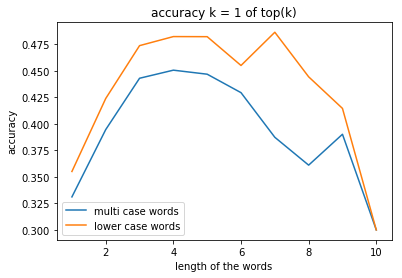

In [17]:
plt.plot(range(1,11), all_vals, label='multi case words')
plt.plot(range(1,11), lower_vals, label='lower case words')
plt.title('accuracy k = 1 of top(k)')
plt.xlabel('length of the words')
plt.ylabel('accuracy')
plt.legend()
plt.show()

the accuracy is: 0.473846153846
************************************************************************
************************************************************************
Original image:


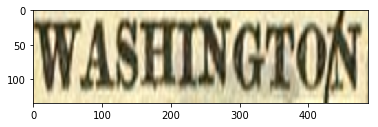

the origninal word is : washington
the matched words are (inorder): ['washington']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


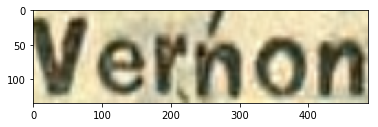

the origninal word is : vernon
the matched words are (inorder): ['vernon']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


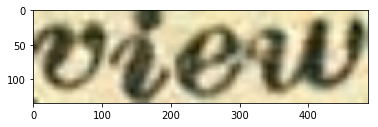

the origninal word is : view
the matched words are (inorder): ['rood']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


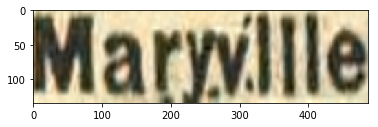

the origninal word is : maryville
the matched words are (inorder): ['maryville']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


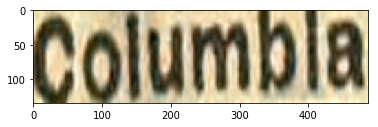

the origninal word is : columbia
the matched words are (inorder): ['montana']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


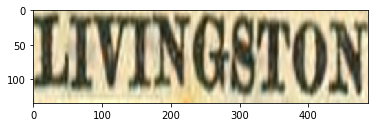

the origninal word is : livingston
the matched words are (inorder): ['herington']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


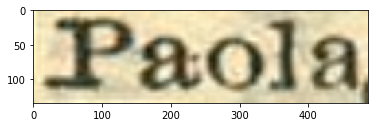

the origninal word is : paola
the matched words are (inorder): ['paola']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


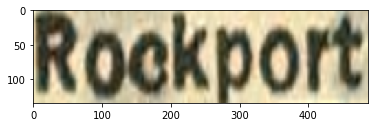

the origninal word is : rockport
the matched words are (inorder): ['rockport']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


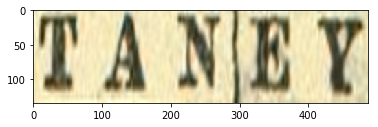

the origninal word is : taney
the matched words are (inorder): ['hanley']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


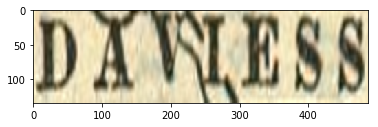

the origninal word is : daviess
the matched words are (inorder): ['davies']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


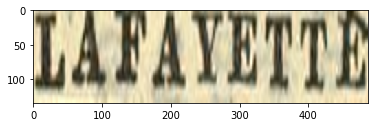

the origninal word is : lafayette
the matched words are (inorder): ['lafayette']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


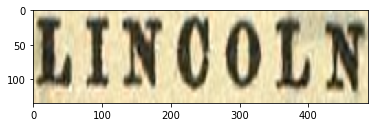

the origninal word is : lincoln
the matched words are (inorder): ['lindon']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


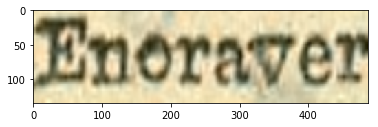

the origninal word is : enoraver
the matched words are (inorder): ['brake']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


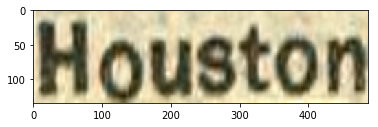

the origninal word is : houston
the matched words are (inorder): ['houston']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


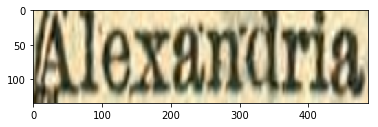

the origninal word is : alexandria
the matched words are (inorder): ['alexandria']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


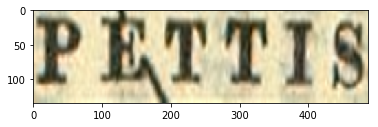

the origninal word is : pettis
the matched words are (inorder): ['pettis']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


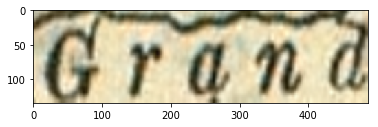

the origninal word is : grand
the matched words are (inorder): ['grand']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


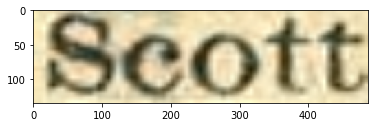

the origninal word is : scott
the matched words are (inorder): ['scott']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


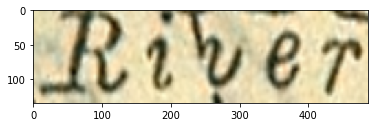

the origninal word is : river
the matched words are (inorder): ['river']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


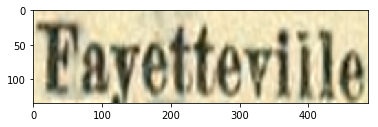

the origninal word is : fayetteville
the matched words are (inorder): ['peytonville']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


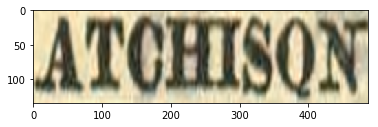

the origninal word is : atchinson
the matched words are (inorder): ['addison']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


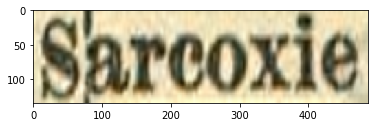

the origninal word is : sarcoxie
the matched words are (inorder): ['sarcoxie']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


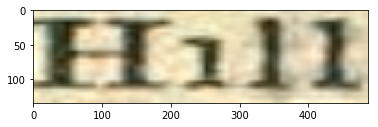

the origninal word is : hill
the matched words are (inorder): ['hill']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


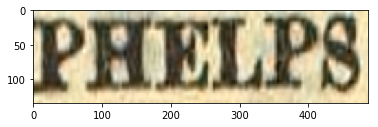

the origninal word is : phelps
the matched words are (inorder): ['keels']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


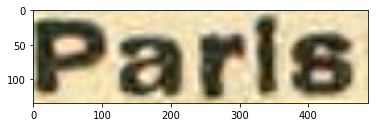

the origninal word is : paris
the matched words are (inorder): ['parma']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


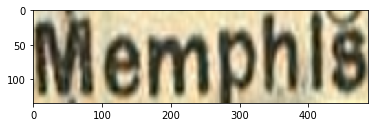

the origninal word is : memphis
the matched words are (inorder): ['memphis']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


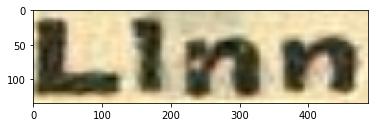

the origninal word is : linn
the matched words are (inorder): ['linn']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


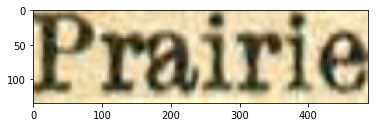

the origninal word is : prairie
the matched words are (inorder): ['prairie']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


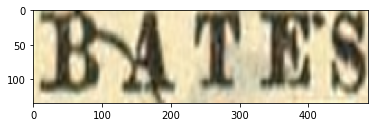

the origninal word is : bates
the matched words are (inorder): ['drakes']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


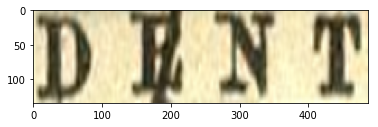

the origninal word is : dent
the matched words are (inorder): ['downs']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


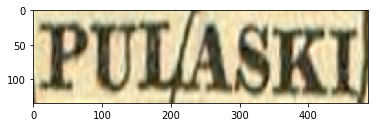

the origninal word is : pulaski
the matched words are (inorder): ['pass']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


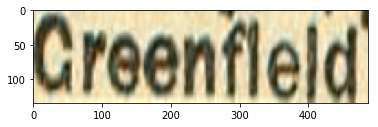

the origninal word is : greenfield
the matched words are (inorder): ['genet']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


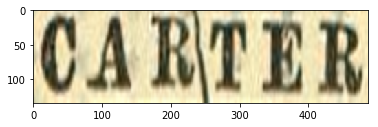

the origninal word is : carter
the matched words are (inorder): ['carter']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


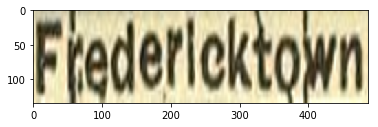

the origninal word is : fredericktown
the matched words are (inorder): ['heaton']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


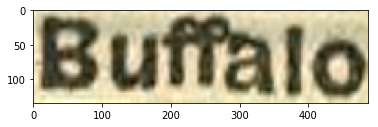

the origninal word is : buffalo
the matched words are (inorder): ['bucado']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


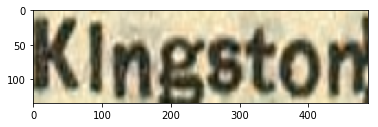

the origninal word is : kingston
the matched words are (inorder): ['johnston']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


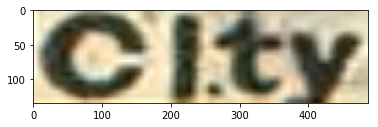

the origninal word is : city
the matched words are (inorder): ['cott']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


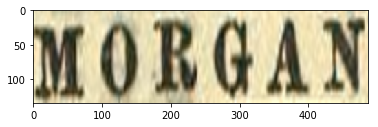

the origninal word is : morgan
the matched words are (inorder): ['morgan']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


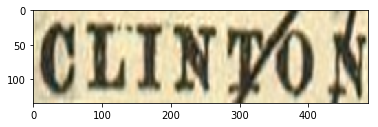

the origninal word is : clinton
the matched words are (inorder): ['clinton']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


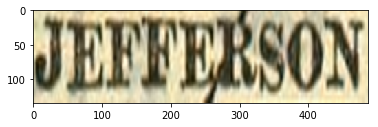

the origninal word is : jefferson
the matched words are (inorder): ['jefferson']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


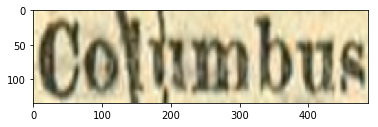

the origninal word is : columbus
the matched words are (inorder): ['columbus']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


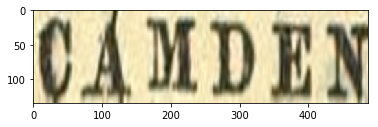

the origninal word is : camden
the matched words are (inorder): ['garden']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


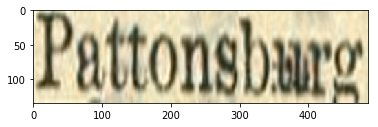

the origninal word is : pattonsburg
the matched words are (inorder): ['pattonsburg']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


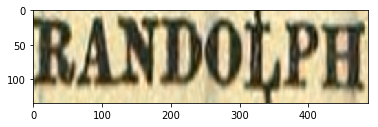

the origninal word is : randolph
the matched words are (inorder): ['randolph']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


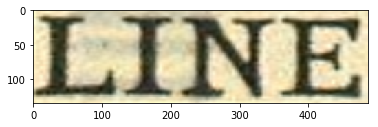

the origninal word is : line
the matched words are (inorder): ['line']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


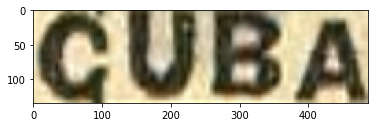

the origninal word is : cuba
the matched words are (inorder): ['gorin']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


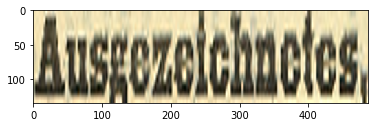

In [ ]:
count, close_count, matched_words, new_outputs, new_embedding, new_word_strings, \
        qualified_ids = report_matches(outputs, embedding, 'cosine', word_strings, \
                                       original_words, k=1, length=3, is_lower=is_lower)

print "the accuracy is: "+str(count/float(len(qualified_ids)))
#print "the close_count accuracy is: "+str(close_count/float(len(original_words)))

_len = min(500, len(matched_words))
new_images = images[qualified_ids]
original_words = np.array(original_words)
original_words = original_words[qualified_ids]
for i in range(_len):
    print "************************************************************************"
    print "************************************************************************"
    print "Original image:"
    q = np.transpose(new_images[i],(1,2,0))
    plt.imshow(q)
    plt.show()
    print "the origninal word is : "+str(original_words[i])
    print "the matched words are (inorder): "+str(matched_words[i])
    print "------------------------------------------------------------------------"
    print "------------------------------------------------------------------------"